<a href="https://colab.research.google.com/github/kaisarmasum/Quantum-Machine-Learning/blob/main/Text_Similarity_QML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PennyLane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [ ]:
import argparse
import string

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import SGD
import torch.nn.functional as F

import pennylane as qml

In [ ]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

class QCBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, context_size, hidden_size=512, n_qlayers=2, n_qubits=8):
        super(QCBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_size)
        # dressed quantum layer
        self.lin1 = nn.Linear(self.context_size * 2 * self.embedding_size, n_qubits)
        self.weight_shapes = {"weights": (n_qlayers, n_qubits)}
        self.qlayer = qml.qnn.TorchLayer(qnode, self.weight_shapes)
        self.lin2 = nn.Linear(n_qubits, self.vocab_size)


    def forward(self, inp):
        out = self.embeddings(inp).view(1, -1)
        out = out.view(1, -1)
        out = self.lin1(out)
        out = F.relu(out)
        out = self.qlayer(out)
        out = self.lin2(out)
        out = F.log_softmax(out, dim=1)
        return out

    def get_word_vector(self, word_idx):
        word = Variable(torch.LongTensor([word_idx]))
        return self.embeddings(word).view(1, -1)

In [ ]:
def train_cbow(cbow, data, unique_vocab, word_to_idx, n_epochs=20, lr=0.01):

    nll_loss = nn.NLLLoss()  # loss function
    optimizer = SGD(cbow.parameters(), lr=lr)

    print("Starting model training...")

    history = {
        'epoch': [],
        'loss': []
    }
    for iepoch in range(n_epochs):
        total_loss = 0
        for context, target in data:
            inp_var = Variable(torch.LongTensor([word_to_idx[word] for word in context]))
            target_var = Variable(torch.LongTensor([word_to_idx[target]]))

            cbow.zero_grad()
            log_prob = cbow(inp_var)
            loss = nll_loss(log_prob, target_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.data

        loss_avg = float(total_loss / len(data))
        print("{}/{} loss {:.2f}".format(iepoch, n_epochs, loss_avg))
        history['loss'].append(loss_avg)
        history['epoch'].append(iepoch)
    return history

In [ ]:
def test_cbow(cbow, unique_vocab, word_to_idx):
    # test word similarity
    word_1 = unique_vocab[2]
    word_2 = unique_vocab[3]

    word_1_vec = cbow.get_word_vector(word_to_idx[word_1])[0]
    word_2_vec = cbow.get_word_vector(word_to_idx[word_2])[0]

    word_similarity = (word_1_vec.dot(word_2_vec) / (torch.norm(word_1_vec) * torch.norm(word_2_vec))).data.numpy()
    print("Similarity between '{}' & '{}' : {:0.4f}".format(word_1, word_2, word_similarity))

In [ ]:
corpus_text = "This tutorial will walk you through the key ideas of deep learning programming using Pytorch." \
              " Many of the concepts (such as the computation graph abstraction and autograd) " \
              "are not unique to Pytorch and are relevant to any deep learning tool kit out there."

In [ ]:
corpus_text

'This tutorial will walk you through the key ideas of deep learning programming using Pytorch. Many of the concepts (such as the computation graph abstraction and autograd) are not unique to Pytorch and are relevant to any deep learning tool kit out there.'

In [ ]:
def main(corpus_text, context_size, embed_dim, n_epochs=20, lr=0.01):
    # consider 2*context_size as context window where middle word as target
    corpus_text = corpus_text.split(' ')
    for i in range(len(corpus_text)):
        sentence = corpus_text[i]
        cleaned_sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        cleaned_sentence = cleaned_sentence.lower()
        corpus_text[i] = cleaned_sentence
    unique_vocab = list(set(corpus_text))
    unique_vocab = sorted(unique_vocab)
    vocab_size = len(unique_vocab)
    print(f"There are {vocab_size} unique words in the vocabulary")
    # mapping to index
    word_to_idx = {w: i for i, w in enumerate(unique_vocab)}
    print(word_to_idx)

    data = list()
    for i in range(context_size, len(corpus_text) - context_size):
        data_context = list()
        for j in range(context_size):
            data_context.append(corpus_text[i - context_size + j])

        for j in range(1, context_size + 1):
            data_context.append(corpus_text[i + j])
        data_target = corpus_text[i]
        data.append((data_context, data_target))

    print("Some data: ",data[:3])

    train_data, test_data = train_test_split(data, test_size=0.2)
    print(f"Training set size: {len(train_data)}")
    print(f"Test set size: {len(test_data)}")
    # define and train model
    #cbow = CBOW(vocab_size, embed_dim, context_size)
    cbow = QCBOW(vocab_size, embed_dim, context_size, n_qlayers=2, n_qubits=4)
    history = train_cbow(cbow, train_data, unique_vocab, word_to_idx, n_epochs, lr)

    # get two words similarity
    test_cbow(cbow, unique_vocab, word_to_idx)

    return history

In [ ]:
context_size = 3
embed_dim = 32
n_epochs = 50
lr = 0.1
history = main(corpus_text, context_size, embed_dim, n_epochs, lr=lr)

There are 34 unique words in the vocabulary
{'abstraction': 0, 'and': 1, 'any': 2, 'are': 3, 'as': 4, 'autograd': 5, 'computation': 6, 'concepts': 7, 'deep': 8, 'graph': 9, 'ideas': 10, 'key': 11, 'kit': 12, 'learning': 13, 'many': 14, 'not': 15, 'of': 16, 'out': 17, 'programming': 18, 'pytorch': 19, 'relevant': 20, 'such': 21, 'the': 22, 'there': 23, 'this': 24, 'through': 25, 'to': 26, 'tool': 27, 'tutorial': 28, 'unique': 29, 'using': 30, 'walk': 31, 'will': 32, 'you': 33}
Some data:  [(['this', 'tutorial', 'will', 'you', 'through', 'the'], 'walk'), (['tutorial', 'will', 'walk', 'through', 'the', 'key'], 'you'), (['will', 'walk', 'you', 'the', 'key', 'ideas'], 'through')]
Training set size: 29
Test set size: 8
Starting model training...
0/50 loss 3.57
1/50 loss 3.50
2/50 loss 3.44
3/50 loss 3.36
4/50 loss 3.31
5/50 loss 3.33
6/50 loss 3.31
7/50 loss 3.25
8/50 loss 3.23
9/50 loss 3.21
10/50 loss 3.26
11/50 loss 3.19
12/50 loss 3.15
13/50 loss 3.10
14/50 loss 3.14
15/50 loss 3.18
16/5

<Axes: xlabel='epoch', ylabel='loss'>

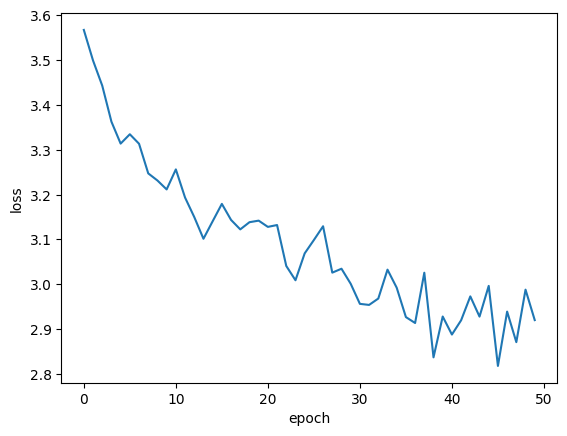

In [ ]:
import seaborn as sns
sns.lineplot(data=history, x='epoch', y='loss')